In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
data = pd.read_csv('heart.csv')
data.info

<bound method DataFrame.info of       age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  target  
0         2

In [3]:
# Has 14 different features
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# In order:
# age
# sex
# chest pain type (4 values)
# resting blood pressure
# serum cholestoral in mg/dl
# fasting blood sugar > 120 mg/dl
# resting electrocardiographic results (values 0,1,2)
# maximum heart rate achieved
# exercise induced angina
# oldpeak = ST depression induced by exercise relative to rest
# the slope of the peak exercise ST segment
# number of major vessels (0-3) colored by flourosopy
# thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

In [5]:
# Check for duplicates
data.duplicated().sum()

723

In [6]:
# Drop them
data = data.drop_duplicates()

In [7]:
data.shape

(302, 14)

In [8]:
count = data['target'].value_counts()
healthy = count[0]
diseased = count[1]

print("Count of healthy people:", healthy)
print("Count of sick people:", diseased)

Count of healthy people: 138
Count of sick people: 164


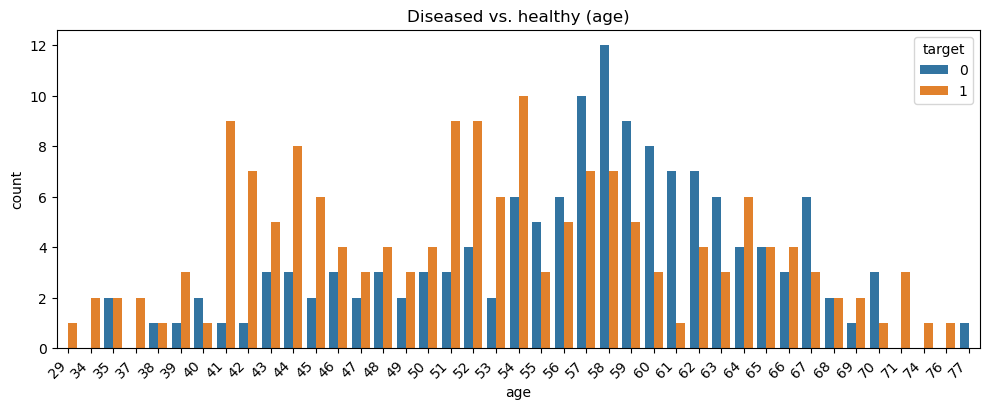

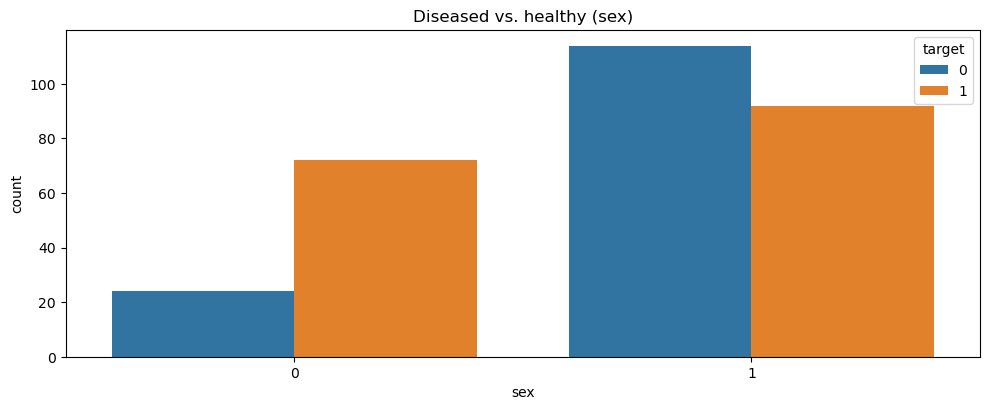

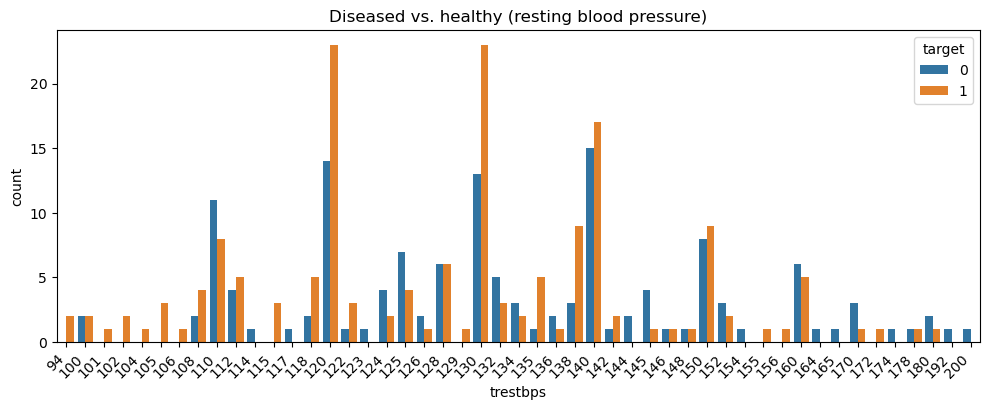

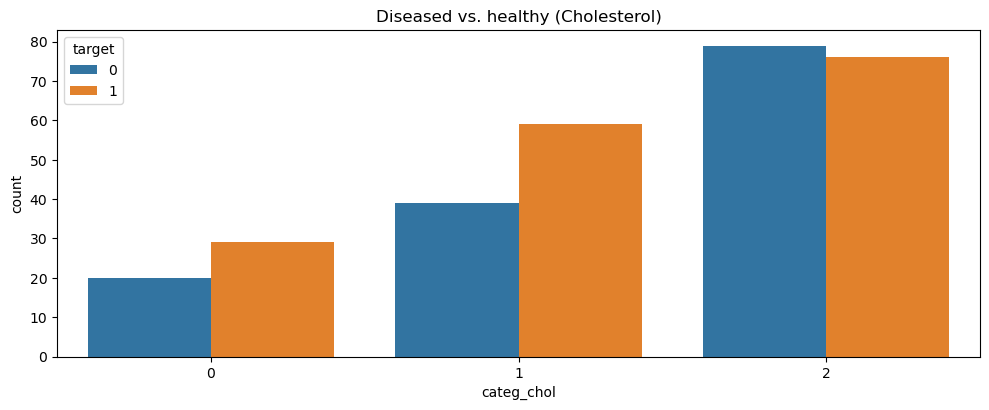

In [9]:
# Let's look some leading risk factors when it comes to heart diseases

plt.figure(figsize=(10, 4))
sns.countplot(x="age", data=data, linewidth=2, hue = "target")
plt.xticks(rotation=45, ha="right") 
plt.tight_layout()
plt.title("Diseased vs. healthy (age)")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x="sex", data=data, linewidth=2, hue = "target")
plt.tight_layout()
plt.title("Diseased vs. healthy (sex)")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x="trestbps", data=data, linewidth=2, hue = "target")
plt.xticks(rotation=45, ha="right") 
plt.tight_layout()
plt.title("Diseased vs. healthy (resting blood pressure)")
plt.show()

# Cholesterol has such a wide range of values, making plotting difficult
# Let's categorize (normal: <200, borderline high:200 to 239, high: >=240)
# Let's give them numerical values [0,1,2]

chol_labels = [0,1,2]
max_chol = data['chol'].max()
min_chol = data['chol'].min()
cut_bins = [min_chol,199, 239, max_chol]
categ_chol = pd.cut(data['chol'], bins = cut_bins,labels = chol_labels, include_lowest=True)
data.insert(5,'categ_chol',categ_chol) 
plt.figure(figsize=(10, 4))
sns.countplot(x="categ_chol", data=data, linewidth=2, hue = "target")
plt.tight_layout()
plt.title("Diseased vs. healthy (Cholesterol)")
plt.show()

In [10]:
# Let's see how the features look in each group
data.head()

,age,sex,cp,trestbps,chol,categ_chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,1,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,1,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,2,1,1,106,0,1.9,1,3,2,0


In [11]:
# Let's see what kind of values we have
data.dtypes

age              int64
sex              int64
cp               int64
trestbps         int64
chol             int64
categ_chol    category
fbs              int64
restecg          int64
thalach          int64
exang            int64
oldpeak        float64
slope            int64
ca               int64
thal             int64
target           int64
dtype: object

In [12]:
# Let's also check that we don't have invalid values
data.isnull().sum()

age           0
sex           0
cp            0
trestbps      0
chol          0
categ_chol    0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
target        0
dtype: int64

In [13]:
# Since there are a lot of variables wtih little data, Random Forest will most likely be our best bet
# Let's extract the data
X=data.iloc[:,0:-1]
y=data["target"]

In [14]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [15]:
X.head()

,age,sex,cp,trestbps,chol,categ_chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,1,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,1,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,2,1,1,106,0,1.9,1,3,2


In [16]:
# Let's drop our categorial cholestrol so we get our original data back
X = X.drop(columns = ["categ_chol"])

In [17]:
# Let's do a basic split of 80:20 in repect to training set and test set
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42)
rf = RandomForestClassifier()
print(X_train.shape)
print(y_train.shape)

(241, 13)
(241,)


In [34]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
print("Accuracy:",acc,"\nPrecision:",prec)

Accuracy: 0.8524590163934426 
Precision: 0.8125


In [19]:
# Let's analyse the performance score with cross validation
np.mean(cross_val_score(RandomForestClassifier(),X,y,scoring='accuracy'))

0.8343169398907104

In [20]:
# Since RandomForest can takes so many different parameters, such as number of trees, depth, samples, which may affect the result as they vary.
# Let's try to find the most optimal parameters using GridSearchCV

In [21]:
# Some parameter values for GridSearch to analyse, when our model is RandomForest

# Number of trees in random forest
n_estimators=[20,60,100,120]

# Number of features to consider at every split
max_features=[0.2,0.6,1.0]

# Maximum number of levels in tree
max_depth=[2,4,8,None]

#Number of samples
max_samples=[0.5,0.75,1.0]

In [22]:
parameter_grid={'n_estimators':n_estimators,
           'max_features': max_features,
           'max_depth':max_depth,
           'max_samples': max_samples
           }
print(parameter_grid)

{'n_estimators': [20, 60, 100, 120], 'max_features': [0.2, 0.6, 1.0], 'max_depth': [2, 4, 8, None], 'max_samples': [0.5, 0.75, 1.0]}


In [23]:
# Let's initialize our GridSearch 
rf_grid=GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=parameter_grid,
                    cv=5,
                    verbose=2,
                    n_jobs=-1)
# And execute
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=2, max_features=0.2, max_samples=0.5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, max_features=0.2, max_samples=0.5, n_estimators=60; total time=   0.1s
[CV] END max_depth=2, max_features=0.2, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, max_features=0.2, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, max_features=0.2, max_samples=0.5, n_estimators=120; total time=   0.3s
[CV] END max_depth=2, max_features=0.2, max_samples=0.75, n_estimators=60; total time=   0.1s
[CV] END max_depth=2, max_features=0.2, max_samples=0.75, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, max_features=0.2, max_samples=0.75, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, max_features=0.2, max_samples=0.75, n_estimators=120; total time=   0.2s
[CV] END max_depth=2, max_features=0.2, max_samples=1.0, n_estimators=60; total time=   0.

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, None],
                         'max_features': [0.2, 0.6, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [20, 60, 100, 120]},
             verbose=2)

In [24]:
rf_grid.best_params_

{'max_depth': 8, 'max_features': 0.2, 'max_samples': 0.5, 'n_estimators': 60}

In [25]:
rf_grid.best_score_

0.842517006802721

In [26]:
# We can also do RandomSearchCV. 
# The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

# In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. 
# The number of parameter settings that are tried is given by n_iter.

# If all parameters are presented as a list, sampling without replacement is performed. 
# If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.

# Number of trees in random forest
n_estimators = [20,60,100,120]

# Number of features to consider at every split
max_features = [0.2,0.6,1.0]

# Maximum number of levels in tree
max_depth = [2,8,None]

# Number of samples
max_samples = [0.5,0.75,1.0]

# Bootstrap samples
bootstrap = [True,False]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

In [27]:
parameter_grid={'n_estimators':n_estimators,
                'max_features': max_features,
                'max_depth':max_depth,
                'max_samples': max_samples,
                'bootstrap': bootstrap,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf
           }
print(parameter_grid)

{'n_estimators': [20, 60, 100, 120], 'max_features': [0.2, 0.6, 1.0], 'max_depth': [2, 8, None], 'max_samples': [0.5, 0.75, 1.0], 'bootstrap': [True, False], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}


In [30]:
rf_grid=RandomizedSearchCV(estimator= RandomForestClassifier(),
                          param_distributions=parameter_grid,
                          cv=5,
                          verbose=2,
                          n_jobs=-1)


In [31]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/software/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/software/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/software/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 397, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/opt/sof

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, None],
                                        'max_features': [0.2, 0.6, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [20, 60, 100, 120]},
                   verbose=2)

In [32]:
rf_grid.best_params_

{'n_estimators': 120,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_samples': 1.0,
 'max_features': 0.2,
 'max_depth': 8,
 'bootstrap': True}

In [33]:
rf_grid.best_score_

0.8216836734693878